# Фаза 2 • Неделя 8 • Понедельник
## Нейронные сети
### 🔥 PyTorch

In [75]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import torchutils as tu
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics

torch.set_default_device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device)

# import mplcyberpunk
# plt.style.use("cyberpunk")
import numpy as np
import pandas as pd

# from sklearn.model_selection import train_test_split
# from sklearn.feature_selection import f_regression, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

# from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    TargetEncoder,
    FunctionTransformer,
)

sklearn.set_config(transform_output="pandas")

# from category_encoders import CatBoostEncoder

In [76]:
print(f"CUDA доступна: {torch.cuda.is_available()}")
print(f"Количество GPU: {torch.cuda.device_count()}")
print(f"Текущее устройство: {torch.cuda.current_device()}")
print(f"Имя устройства: {torch.cuda.get_device_name(0)}")

CUDA доступна: True
Количество GPU: 1
Текущее устройство: 0
Имя устройства: NVIDIA GeForce RTX 3080


In [77]:
tensor = torch.tensor([1, 2, 3])
print(tensor.device)  # cuda:0

cuda:0



### Оценка стоимости недвижимости с применением нейронных сетей

Загрузите датасет House Prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) с прошлой недели: датасет должен быть предобработанный:

* в нем должны отсутствовать пропуски
* данные **обязательно** должны быть нормализованы
* целевая переменная должна быть логарифмирована
* в `TensorDataset` передаем только массив, а не `DataFrame` 

In [78]:
train = pd.read_csv("./data/train.csv")
X = train.drop("SalePrice", axis=1).copy()
y = np.log(train["SalePrice"].copy())

In [79]:
def new_features(X):
    X["TotalBsmtBath"] = (
        X["BsmtFullBath"] + X["BsmtHalfBath"] * 0.5
    )  # считаем сколько санузлов в подвале, HalfBath умножили на 0.5, потому что это половина)))
    X["TotalBath"] = X["FullBath"] + X["HalfBath"] * 0.5  # то же самое
    X["TotalSquare"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
    X["GarageAgeYrs"] = X["YrSold"] - X["GarageYrBlt"]
    X["TotalLivArea"] = (
        X["GrLivArea"] + X["BsmtFinSF1"] + X["BsmtFinSF2"]
    )  # считаем общую жилую площадь
    X["TotalRooms"] = X["TotRmsAbvGrd"] + X["BedroomAbvGr"]
    X["Age"] = X["YrSold"] - X["YearBuilt"]
    X["Garage"] = X["GarageCars"].map(lambda x: x if x == 0 else 1)
    X["YrsFromRenn"] = X["YrSold"] - X["YearRemodAdd"]
    X["HasBasement"] = (X["TotalBsmtSF"] > 0).astype(int)
    # X["HasGarage"] = (X["GarageArea"] > 0).astype(int)
    X["HasFinishedBsmt"] = ((X["BsmtFinSF1"] + X["BsmtFinSF2"]) > 0).astype(int)
    return X

In [80]:
X = new_features(X)

In [81]:
num_features = [
    "LotFrontage",
    "LotArea",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "GarageYrBlt",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
    "TotalSquare",
    "TotalBath",
    "TotalBsmtBath",
    "GarageAgeYrs",
    "Age",
    "TotalRooms",
    "TotalLivArea",
    "YrsFromRenn",
]
cat_features = []
for c in X.columns:
    if c not in num_features and c != "Id":
        cat_features.append(c)

In [82]:
drop_features = [
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "MasVnrType",
    "Alley",
    "OverallCond",
    "GarageQual",
    "GarageCond",
    "LandContour",
    "MSSubClass",
    "SaleType",
    "LowQualFinSF",
    "LandSlope",
    "MiscVal",
    "Utilities",
    "GarageArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GarageType",
    "GarageYrBlt",
    "GarageFinish",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "GrLivArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "TotRmsAbvGrd",
    "BedroomAbvGr",
    "YrSold",
    "YearBuilt",
    "YearRemodAdd",
]

rest_cat_features = [
    c for c in cat_features if c not in drop_features
]  # все недропнутые категориальные
rest_cat_num_features = [
    c for c in rest_cat_features if X[c].dtypes in (int, float)
]  # отбираем те, которые с цифрами
rest_cat_str_features = [
    c for c in rest_cat_features if c not in rest_cat_num_features
]  # отбираем те,которые с буквами
rest_num_features = [
    c for c in num_features if c not in drop_features
]  # числовые признаки

imputer = ColumnTransformer(
    transformers=[
        ("drop_features", "drop", drop_features),
        (
            "imput_no",
            SimpleImputer(strategy="constant", fill_value="no"),
            rest_cat_str_features,
        ),  # type: ignore
        (
            "imput_0",
            SimpleImputer(strategy="constant", fill_value=0),
            rest_cat_num_features,
        ),
        (
            "imput_numeric",
            SimpleImputer(strategy="median"),
            rest_num_features,
            # [c for c in num_features if c not in drop_features],
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
# list(set(cat_features) - set(drop_features))
# len([c for c in cat_features if c not in drop_features])
all_features = rest_num_features + rest_cat_num_features + rest_cat_str_features
len(all_features)

55

In [83]:
# X_imput = imputer.fit_transform(X)

In [84]:
# X_imput[rest_num_features].dtypes

In [85]:
scaler = ColumnTransformer(
    [("scaling_num_columns", StandardScaler(), rest_num_features)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [86]:
def log(x):

    if np.all(x > 0):
        return np.log(x)
    return x


log_transformer = ColumnTransformer(
    [("log", FunctionTransformer(log), rest_num_features)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [87]:
def float_to_int(x):
    return x.astype(int)


to_int = FunctionTransformer(float_to_int)

encoder = ColumnTransformer(
    [("encoding", make_pipeline(OrdinalEncoder()), rest_cat_features)],
    # [("encoding", CatBoostEncoder(), rest_cat_features)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [88]:
preprocessor = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("log", log_transformer),
        ("scaler", scaler),
    ]
)

In [89]:
y = pd.DataFrame(y)
y

,SalePrice
0,12.247694
1,12.109011
2,12.317167
3,11.849398
4,12.429216
...,...
1455,12.072541
1456,12.254863
1457,12.493130
1458,11.864462


In [90]:
y_scaler = ColumnTransformer(
    [("scaling_y", StandardScaler(), [0])],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [91]:
# y = y_scaler.fit_transform(y)

''

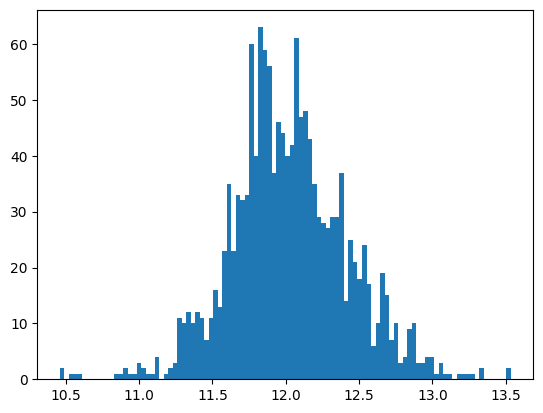

In [92]:
plt.hist(y["SalePrice"], bins=100)
;

In [93]:
X = preprocessor.fit_transform(X)
X

,LotFrontage,LotArea,MasVnrArea,BsmtUnfSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,TotalSquare,...,Fireplaces,FireplaceQu,GarageCars,PavedDrive,MoSold,SaleCondition,Garage,HasBasement,HasFinishedBsmt,Id
0,-0.220875,-0.207142,0.514104,-0.944591,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.001277,...,0.0,5.0,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1
1,0.460320,-0.091886,-0.570750,-0.641228,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.052407,...,1.0,4.0,2.0,2.0,4.0,4.0,1.0,1.0,1.0,2
2,-0.084636,0.073480,0.325915,-0.301643,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,0.169157,...,1.0,4.0,2.0,2.0,8.0,4.0,1.0,1.0,1.0,3
3,-0.447940,-0.096897,-0.570750,-0.061670,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.114493,...,1.0,2.0,3.0,2.0,1.0,0.0,1.0,1.0,1.0,4
4,0.641972,0.375148,1.366489,-0.174865,0.780197,0.563760,-0.359325,-0.116339,-0.270208,0.944631,...,1.0,4.0,3.0,2.0,11.0,4.0,1.0,1.0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.357114,-0.260560,-0.570750,0.873321,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,0.040114,...,1.0,4.0,2.0,2.0,7.0,4.0,1.0,1.0,0.0,1456
1456,0.687385,0.266407,0.087911,0.049262,2.033231,-0.704483,-0.359325,-0.116339,-0.270208,1.275760,...,2.0,4.0,2.0,2.0,1.0,4.0,1.0,1.0,1.0,1457
1457,-0.175462,-0.147810,-0.570750,0.701265,-0.752176,0.201405,-0.359325,-0.116339,-0.270208,1.126022,...,2.0,2.0,1.0,2.0,4.0,4.0,1.0,1.0,1.0,1458
1458,-0.084636,-0.080160,-0.570750,-1.284176,2.168910,-0.704483,1.473789,-0.116339,-0.270208,-0.500404,...,0.0,5.0,1.0,2.0,3.0,4.0,1.0,1.0,1.0,1459


In [94]:
X.to_csv("data/X.csv")
y.to_csv("data/y.csv")

In [95]:
nans = X.isna().sum()
nans[nans != 0]

Series([], dtype: int64)

In [96]:
X.dtypes[X.dtypes == object]

Series([], dtype: object)

In [97]:
n_features = X.shape[1]
n_features

56

In [98]:
X.iloc[:, :].values

array([[-2.20875089e-01, -2.07141708e-01,  5.14103891e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 4.60319735e-01, -9.18863723e-02, -5.70750134e-01, ...,
         1.00000000e+00,  1.00000000e+00,  2.00000000e+00],
       [-8.46361241e-02,  7.34799786e-02,  3.25914928e-01, ...,
         1.00000000e+00,  1.00000000e+00,  3.00000000e+00],
       ...,
       [-1.75462101e-01, -1.47810266e-01, -5.70750134e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.45800000e+03],
       [-8.46361241e-02, -8.01603947e-02, -5.70750134e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.45900000e+03],
       [ 2.33254794e-01, -5.81115479e-02, -5.70750134e-01, ...,
         1.00000000e+00,  1.00000000e+00,  1.46000000e+03]],
      shape=(1460, 56))

In [99]:
torch.tensor(X.iloc[:, :].values, dtype=torch.float)

tensor([[-2.2088e-01, -2.0714e-01,  5.1410e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        [ 4.6032e-01, -9.1886e-02, -5.7075e-01,  ...,  1.0000e+00,
          1.0000e+00,  2.0000e+00],
        [-8.4636e-02,  7.3480e-02,  3.2591e-01,  ...,  1.0000e+00,
          1.0000e+00,  3.0000e+00],
        ...,
        [-1.7546e-01, -1.4781e-01, -5.7075e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.4580e+03],
        [-8.4636e-02, -8.0160e-02, -5.7075e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.4590e+03],
        [ 2.3325e-01, -5.8112e-02, -5.7075e-01,  ...,  1.0000e+00,
          1.0000e+00,  1.4600e+03]], device='cuda:0')

1. С использованием библиотеки `pytorch` задай нейронную сеть по следующей схеме: 
    * На первом слое 128 нейронов с активацией `relu`
    * На втором слое 64 нейрона с активацией `relu`
    * На третьем слое дропаут с аргументом 0.5
    * Выходной слой из 1 нейрона

![](aux/baseline.png)

In [100]:
model = nn.Sequential(
    nn.Linear(n_features, 64),
    nn.BatchNorm1d(64),
    nn.Sigmoid(),
    nn.Linear(64, 128),
    nn.BatchNorm1d(128),
    nn.Sigmoid(),
    nn.Linear(128, 256),
    nn.BatchNorm1d(256),
    nn.Sigmoid(),
    nn.Linear(256, 512),
    nn.BatchNorm1d(512),
    nn.Sigmoid(),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.Sigmoid(),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.Sigmoid(),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.Sigmoid(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.Sigmoid(),
    # nn.Linear(128, 128),
    # nn.Sigmoid(),
    # nn.Linear(128, 128),
    # nn.Sigmoid(),
    # nn.Linear(128, 128),
    # nn.Sigmoid(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.Sigmoid(),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.Sigmoid(),
    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.Sigmoid(),
    nn.Linear(16, 8),
    nn.BatchNorm1d(8),
    nn.Sigmoid(),
    nn.Linear(8, 4),
    nn.BatchNorm1d(4),
    nn.Sigmoid(),
    nn.Linear(4, 2),
    nn.BatchNorm1d(2),
    nn.Sigmoid(),
    nn.Linear(2, 1),
)
# model = nn.Sequential(
#     nn.Linear(n_features, 64),
#     nn.Tanh(),
#     nn.Linear(64, 64),
#     nn.Tanh(),
#     # nn.Linear(64, 64),
#     # nn.Tanh(),
#     # nn.Linear(64, 32),
#     # nn.Tanh(),
#     # nn.Linear(32, 16),
#     # nn.Tanh(),
#     # nn.Linear(16, 8),
#     # nn.Tanh(),
#     # # nn.Linear(32, 16),
#     # # nn.Tanh(),
#     # # nn.Linear(16, 8),
#     # # nn.Tanh(),
#     # nn.Linear(8, 4),
#     # nn.Tanh(),
#     # nn.Linear(4, 2),
#     # nn.Tanh(),
#     # # nn.Dropout(p=0.5),
#     nn.Linear(64, 1),
# )
model = model.to(device)

2. Вызови `tu.get_model_summary` модели

In [101]:
tu.get_model_summary(model, torch.randn(90, n_features))

Layer     Kernel        Output     Params         FLOPs
0_0        [56, 64]     [90, 64]     3,648      639,360
1_1            [64]     [90, 64]       128       23,040
2_2               -     [90, 64]         0       23,040
3_3       [64, 128]    [90, 128]     8,320    1,463,040
4_4           [128]    [90, 128]       256       46,080
5_5               -    [90, 128]         0       46,080
6_6      [128, 256]    [90, 256]    33,024    5,875,200
7_7           [256]    [90, 256]       512       92,160
8_8               -    [90, 256]         0       92,160
9_9      [256, 512]    [90, 512]   131,584   23,546,880
10_10         [512]    [90, 512]     1,024      184,320
11_11             -    [90, 512]         0      184,320
12_12   [512, 1024]   [90, 1024]   525,312   94,279,680
13_13        [1024]   [90, 1024]     2,048      368,640
14_14             -   [90, 1024]         0      368,640
15_15   [1024, 512]    [90, 512]   524,800   94,325,760
16_16         [512]    [90, 512]     1,024      

3. Импортируй `TensorDataset` и `DataLoader` и создай датасет для обучения модели. 

In [102]:
dataset = TensorDataset(
    torch.tensor(X.iloc[:, :].values, dtype=torch.float),
    torch.tensor(y.iloc[:, :].values, dtype=torch.float),
)

In [103]:
dataset

In [104]:
train_ds, valid_ds = random_split(dataset, lengths=(0.7, 0.3), generator=generator)

In [105]:
train_loader = DataLoader(train_ds, shuffle=True, batch_size=32, generator=generator)
valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=32, generator=generator)

In [106]:
next(iter(train_loader))

[tensor([[ 4.6032e-01, -1.1709e-02,  1.0233e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.3600e+02],
         [ 2.3223e+00,  5.5545e-01,  1.0012e+00,  ...,  1.0000e+00,
           0.0000e+00,  8.6000e+01],
         [-4.4794e-01, -3.3242e-01, -1.9437e-01,  ...,  1.0000e+00,
           1.0000e+00,  2.8200e+02],
         ...,
         [-3.9223e-02, -1.0191e-01,  7.9639e-01,  ...,  1.0000e+00,
           1.0000e+00,  3.6700e+02],
         [-1.3562e+00, -5.8588e-01, -5.7075e-01,  ...,  1.0000e+00,
           1.0000e+00,  7.1300e+02],
         [-3.9223e-02, -2.0464e-01, -5.7075e-01,  ...,  1.0000e+00,
           1.0000e+00,  7.7000e+01]], device='cuda:0'),
 tensor([[12.0668],
         [12.4684],
         [12.1281],
         [12.5461],
         [12.0895],
         [11.6784],
         [12.0598],
         [12.1200],
         [12.5425],
         [11.7519],
         [12.0782],
         [12.4912],
         [11.7924],
         [12.4292],
         [12.3234],
         [12.3545],
         [12.0494

In [107]:
def plot_loss_metrics_regression(
    tl: list, vl: list, tm: list, vm: list, tr2: list, vr2: list
):
    _, ax = plt.subplots(2, 2, figsize=(14, 10))
    ax[0][0].plot(tl, label="Train loss")
    ax[0][0].plot(vl, label="Valid Loss")
    ax[0][0].legend()
    ax[0][0].set_title("Loss")
    ax[0][0].set_ylim((0, max(tl + vl) + 0.1))

    ax[0][1].plot(tm, label="Train RMSE")
    ax[0][1].plot(vm, label="Valid RMSE")
    ax[0][1].legend()
    ax[0][1].set_title("RMSE")
    ax[0][1].set_ylim((0, max(tm + vm) + 0.1))

    ax[1][0].plot(tr2, label="Train R2")
    ax[1][0].plot(vr2, label="Valid R2")
    ax[1][0].legend()
    ax[1][0].set_title("R2-score")
    # ax[1][0].set_ylim((0, max(tr2 + vr2) + 0.1))

4. Создай оптимизатор и задай функцию потерь (она не может быть той же, что и в демо-файле)

In [108]:
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

5. Запусти обучение на 10 эпох и нарисуй кривые обучения и кривые изменения метрик. Не забудь переводить модель в режимы `train` и `eval`. 
    Не забудь о том, что метрика на этот раз должна быть регрессионной, а не классификационной (как в демо файле). 

In [109]:
# Функция расчета метрики на GPU
def calculate_rmse_torch(preds, targets):
    # Вычисление метрики прямо на GPU без перехода на numpy
    if preds.device != targets.device:
        targets = targets.to(preds.device)
    # Вычисление RMSE на GPU
    mse = torch.mean((preds - targets) ** 2)
    rmse = torch.sqrt(mse)

    return rmse.item()


def calculate_r2_torch(preds: torch.Tensor, targets: torch.Tensor):

    # preds_np = preds.detach().cpu().numpy()
    # targets_np = targets.detach().cpu().numpy()
    # # Вычисление R² score
    # ss_res = np.sum((targets_np - preds_np) ** 2)
    # ss_tot = np.sum((targets_np - targets_np.mean()) ** 2)

    # # Добавляем маленькое значение для избежания деления на ноль
    # # r2 = 1 - (
    # #     (ss_res * (len(preds_np) - 1))
    # #     / ((ss_tot + 1e-8) * (len(preds_np) - 1 - n_features))
    # # )

    # return r2
    """
    Вычисляет R² score полностью на GPU.
    """
    # Убедимся, что тензоры на одном устройстве
    if preds.device != targets.device:
        targets = targets.to(preds.device)

    ss_res = torch.sum((targets - preds) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)

    return (1 - (ss_res / ss_tot)).item()

In [110]:
def fit_model(model: torch.nn.modules.container.Sequential, n_epochs: int) -> tuple:

    # будем сохранять историю обучения модели: значения функции потерь и метрики accuracy
    # эти переменные будут отвечать за хранение значений после вычисления каждой эпохи
    train_losses = []
    valid_losses = []

    train_metric = []
    valid_metric = []

    train_r2 = []
    valid_r2 = []

    for epoch in range(n_epochs):
        ####### ОБУЧЕНИЕ ##########
        model.train()  # устанавливаем модель в режим обучения – сейчас будут вычисляться градиенты

        # эти два списка будут хранить значения внутри одной итерации
        train_loss_iter = []
        train_metric_iter = []
        train_r2_iter = []

        # внутри одной эпохи итерируемся по загрузчику: обычно памяти меньше,
        # чем данных, поэтому сразу взять всю выборку не получится
        for samples, labels in train_loader:

            samples, labels = samples.to(device), labels.to(device)

            # получаем предсказания модели, т.е. делаем прямой проход – forward pass
            predictions = model(samples)

            # (128, 1) X (128)
            # на выходе из модели форма predictions (batch_size, 1), а форма labels – (batch_size, )
            # нам нужно убрать одно измерение из predictions, это можно сделать с
            # помощью метода squeeze(-1)
            predictions = predictions.squeeze(-1)

            # считаем значение функции потерь: сравниваем
            # прогнозы модели с истинными значениями классов
            loss = criterion(predictions, labels)

            # обнуляем значения градиентов с предыдущего шага – pytorch этого не делает за нас
            optimizer.zero_grad()
            # делаем обратный проход – backward
            loss.backward()
            # применяем вычисленные градиенты к параметрам
            optimizer.step()

            # запишем loss в список
            train_loss_iter.append(loss.item())

            # вычислим точность: число совпавших классов в предсказании модели и настоящих меток
            # accuracy = (torch.round(predictions) == labels).sum() / len(samples)
            rmse = calculate_rmse_torch(predictions, labels)
            r2 = calculate_r2_torch(predictions, labels)
            train_metric_iter.append(rmse)
            train_r2_iter.append(r2)

        ###### ВАЛИДАЦИЯ ###########
        # Теперь будем идти по валидационному загрузчику и проверять качество модели на другой выборке
        # переводим модель в режим валидации
        model.eval()

        valid_loss_iter = []
        valid_metric_iter = []
        valid_r2_iter = []

        for samples, labels in valid_loader:

            samples, labels = samples.to(device), labels.to(device)
            # получаем предсказания модели, т.е. делаем прямой проход – forward pass
            # делаем это с отключенной функцией вычисления градиентов, нам это ни к чему
            # во время проверки точности модели на валидационной части выборки
            # with torch.inference_mode:
            with torch.inference_mode():
                predictions = model(samples)

            # на выходе из модели форма predictions (batch_size, 1), а форма labels – (batch_size, )
            # нам нужно убрать одно измерение из predictions, это можно сделать с
            # помощью метода squeeze(-1)
            predictions = predictions.squeeze(-1)

            # считаем значение функции потерь: сравниваем прогнозы модели с истинными значениями классов
            loss = criterion(predictions, labels)

            # запишем loss в список, item() забирает только значение из переменной, не тянет за собой техническую информацию
            valid_loss_iter.append(loss.item())

            # вычислим точность: число совпавших классов в предсказании модели и настоящих меток
            rmse = calculate_rmse_torch(predictions, labels)
            valid_metric_iter.append(rmse)
            # print(predictions.detach().cpu()[0:10].item())
            # print(np.array(labels.detach().cpu()[0:10]))
            r2 = calculate_r2_torch(predictions, labels)
            valid_r2_iter.append(r2)

        # после окончания эпохи запишем все усредненные характеристики в переменные
        train_losses.append(np.mean(train_loss_iter))
        valid_losses.append(np.mean(valid_loss_iter))

        train_metric.append(np.mean(train_metric_iter))
        valid_metric.append(np.mean(valid_metric_iter))

        train_r2.append(np.mean(train_r2_iter))
        valid_r2.append(np.mean(valid_r2_iter))

        if epoch % 1 == 0:
            print(
                f"Epoch {epoch} finished: train_loss={train_losses[-1]:.3f}, valid_loss={valid_losses[-1]:.3f}, RMSE_valid={valid_metric[-1]}"
            )

    return train_losses, valid_losses, train_metric, valid_metric, train_r2, valid_r2

In [111]:
train_losses, valid_losses, train_metric, valid_metric, train_r2, valid_r2 = fit_model(
    model, 1000
)

/home/dmitry/elbrus/Phase2/ds-phase-2-git/week1/.venv/lib/python3.12/site-packages/torch/utils/_device.py:103: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/home/dmitry/elbrus/Phase2/ds-phase-2-git/week1/.venv/lib/python3.12/site-packages/torch/utils/_device.py:103: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/home/dmitry/elbrus/Phase2/ds-phase-2-git/week1/.venv/lib/python3.12/site-packages/torch/utils/_device.py:103: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([22])). This will likely lead to incorrect results due to broadcasting. Pl

Epoch 0 finished: train_loss=143.917, valid_loss=139.749, RMSE_valid=11.821322577340263
Epoch 1 finished: train_loss=135.635, valid_loss=130.943, RMSE_valid=11.442921570369176
Epoch 2 finished: train_loss=127.548, valid_loss=121.535, RMSE_valid=11.024189267839704
Epoch 3 finished: train_loss=119.544, valid_loss=114.763, RMSE_valid=10.712507247924805
Epoch 4 finished: train_loss=111.515, valid_loss=107.399, RMSE_valid=10.36304099219186
Epoch 5 finished: train_loss=103.421, valid_loss=100.320, RMSE_valid=10.015706675393242
Epoch 6 finished: train_loss=95.189, valid_loss=91.481, RMSE_valid=9.564263207571846
Epoch 7 finished: train_loss=86.854, valid_loss=79.070, RMSE_valid=8.891911438533239
Epoch 8 finished: train_loss=78.628, valid_loss=74.568, RMSE_valid=8.634878499167305
Epoch 9 finished: train_loss=70.572, valid_loss=63.850, RMSE_valid=7.990159205027989
Epoch 10 finished: train_loss=63.082, valid_loss=57.344, RMSE_valid=7.5724446432931085
Epoch 11 finished: train_loss=56.008, valid_lo

KeyboardInterrupt: 

In [ ]:
print(train_r2[-1])
print(valid_r2[-1])

-32.00921446084976
-31.287037576947892


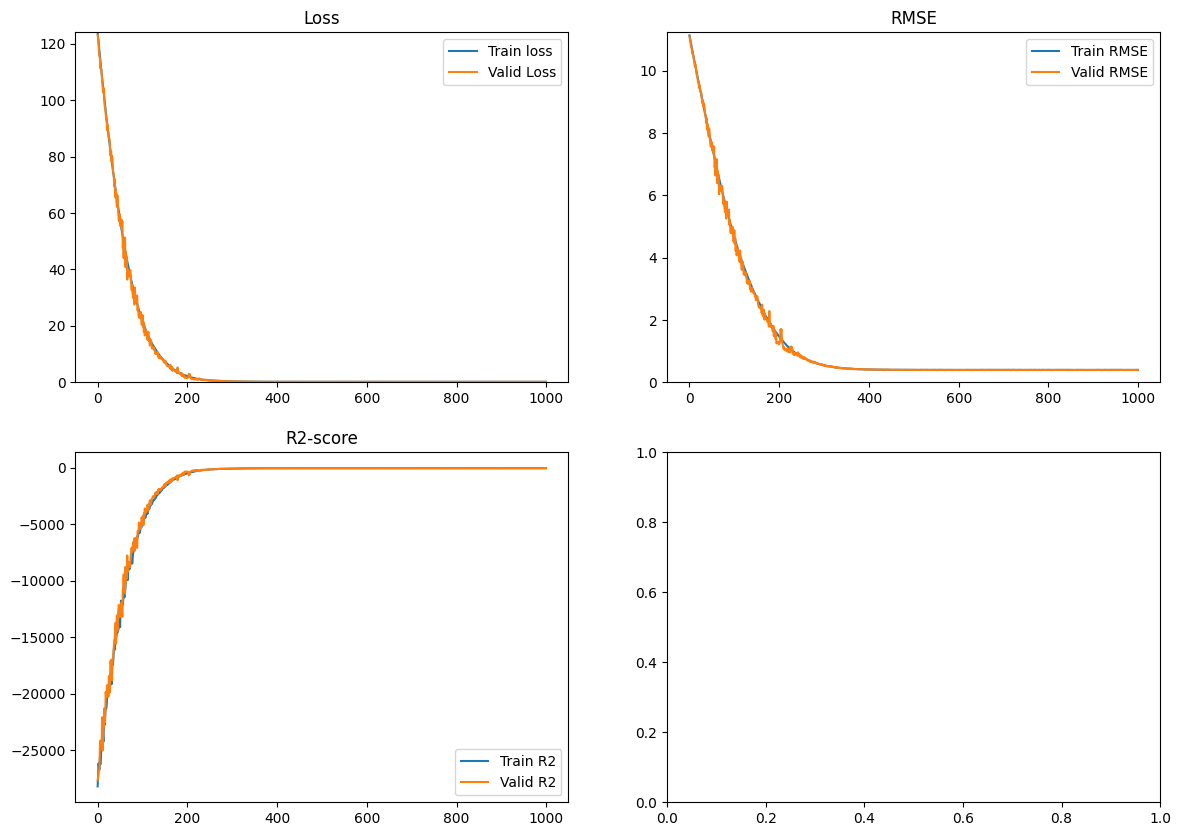

In [ ]:
plot_loss_metrics_regression(
    train_losses, valid_losses, train_metric, valid_metric, train_r2, valid_r2
)

In [ ]:
test = pd.read_csv("data/test.csv")
test_new_features = new_features(test.copy())
test_preproc = preprocessor.fit_transform(test_new_features.copy())
test_preproc_tensor = torch.tensor(test_preproc.iloc[:, :].values, dtype=torch.float)

In [ ]:
model.eval()  # режим инференса

with torch.no_grad():  # отключаем градиенты
    preds = model(test_preproc_tensor)

test["SalePrice"] = np.exp(preds.detach().cpu())
result = test.loc[:, ["Id", "SalePrice"]]

/tmp/ipykernel_278591/2044497519.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test["SalePrice"] = np.exp(preds.detach().cpu())


In [ ]:
result.to_csv("./data/result_final.csv", index=False)

6. Измени архитектуру модели и улучши результат: 
    * измени число нейронов
    * попробуй использовать сигмоидную функцию активации: `nn.Sigmoid`
    * измени число слоев
    * поэкспериментируй с активационными функциями и дропаутом

7. Попробуй добиться лучшего результата, чем получалось на прошлой неделе во время выполнения проекта!

## Дополнительное задание

### Классификация клиента банка 

* С помощью `pytorch` классифицировать клиентов банка. 

* Датасет [здесь](https://raw.githubusercontent.com/Anurion/Uralsib_test/main/Uralsib_test/Data.txt)

* Метрика: `f1_score`

* При чтении данных нужно указать аргумент `read_csv()` `encoding='kz1048'`